# Testing Conditional Mutual Information


In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path
from pprint import pprint
import json
import collections
from itertools import combinations, chain

import numpy as np
import bnlearn as bn
import networkx as nx
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from numpy.random import Generator, PCG64
import pingouin as pg

from dodiscover.ci import CMITest

from causal_networkx import DAG, StructuralCausalModel

from causal_networkx.ci import (
    Oracle,
    KernelCITest,
)

from dodiscover.ci.simulate import nonlinear_additive_gaussian

import matplotlib.pyplot as plt
import seaborn as sns

ImportError: cannot import name 'CMITest' from 'dodiscover.ci' (/Users/adam2392/Documents/dodiscover/dodiscover/ci/__init__.py)

In [6]:
graph = np.array(
    [[[0.2, 0.0, 0.0], [0.5, 0.0, 0.0]], [[0.0, 0.1, 0.0], [0.3, 0.0, 0.0]]]
)
print(graph)
print(graph.shape)
print(graph[..., 0])
print(graph[..., 1])
print(graph[..., 2])

[[[0.2 0.  0. ]
  [0.5 0.  0. ]]

 [[0.  0.1 0. ]
  [0.3 0.  0. ]]]
(2, 2, 3)
[[0.2 0.5]
 [0.  0.3]]
[[0.  0. ]
 [0.1 0. ]]
[[0. 0.]
 [0. 0.]]


## Work with a linear SCM

In [4]:
seed = 12345
rng = Generator(PCG64(seed))

# func_uxy = rng.uniform
func_uz = rng.normal
func_ux = rng.normal
func_uy = lambda: rng.normal()  # (scale=5.0)
func_uw = lambda: rng.normal()  # (scale=1.0)

xz_weight = 0.1
xy_weight = 0.1
wy_weight = 0.1

func_z = lambda u_z: u_z
func_x = lambda u_x, z: u_x + xz_weight * z
func_y = lambda u_y, w, x: wy_weight * w + u_y + xy_weight * x
func_w = lambda u_w: u_w

scm = StructuralCausalModel(
    exogenous={
        "u_x": func_ux,
        "u_y": func_uy,
        "u_z": func_uz,
        "u_w": func_uw,
    },
    endogenous={"x": func_x, "z": func_z, "y": func_y, "w": func_w},
)

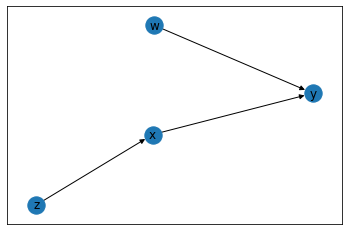

In [45]:
scm.get_causal_graph().draw()

In [46]:
n_samples = 5000
df = scm.sample(n_samples, include_latents=False)
df["noise_var"] = rng.normal(size=(n_samples,))
display(df.head())

,z,x,w,y,noise_var
0,-0.870662,-1.510891,-0.259173,1.086722,-0.834590
1,-1.367793,-0.212123,0.648893,-0.697208,0.248369
2,2.347410,0.595799,0.968497,-1.796433,-0.415533
3,-0.466953,-0.806082,-0.060690,0.815521,0.335198
4,0.575858,0.846430,1.398979,-1.032127,-0.229660


## Try with Tigramite

In [35]:
import tigramite
from tigramite.independence_tests import CMIknn

In [51]:
df = df[["x", "y", "z"]]
display(df.head())

,x,y,z
0,-1.510891,1.086722,-0.870662
1,-0.212123,-0.697208,-1.367793
2,0.595799,-1.796433,2.347410
3,-0.806082,0.815521,-0.466953
4,0.846430,-1.032127,0.575858


In [ ]:
cmi_est = CMIknn()

arr = df.to_numpy().T
dim, T = arr.shape
print(arr.shape)
xyz = np.array([0, 1, 2])
val = cmi_est.get_dependence_measure(arr, xyz)
print(val)

# xyz = np.array([0, 1, -1])
# val = cmi_est.get_dependence_measure(arr, xyz)
# print(val)

if cmi_est.knn < 1:
    knn_here = max(1, int(cmi_est.knn * T))
else:
    knn_here = max(1, int(cmi_est.knn))

# print(knn_here)

k_xz, k_yz, k_z = cmi_est._get_nearest_neighbors(array=arr, xyz=xyz, knn=knn_here)

pval, null_dist = cmi_est.get_shuffle_significance(arr, xyz, val, return_null_dist=True)

print(pval)

sns.displot(null_dist)

(3, 5000)
0.003622249751248141


## With Dodiscover

In [47]:
cmi_est = CMITest(k=5, n_shuffle_nbrs=10)

In [109]:
data = df.copy()
n_samples, n_dims = data.shape

# add minor noise to make sure there are no ties
random_noise = rng.random((n_samples, n_dims))
data += 1e-6 * random_noise @ data.std(axis=0).to_numpy().reshape(n_dims, 1)
# display(data.head())

data = data.rank(axis=0) - 1
display(data.head())

,z,x,w,y,noise_var
0,3744.0,3246.0,6185.0,1740.0,2393.0
1,6878.0,3738.0,663.0,635.0,4983.0
2,1024.0,7614.0,3934.0,199.0,4484.0
3,2366.0,7416.0,3936.0,3442.0,168.0
4,640.0,1390.0,9784.0,8208.0,2098.0


In [83]:
do_k_xz, do_k_yz, do_k_z = cmi_est_._get_knn(data, "x", "y", set())

In [86]:
# compute the significance of the CMI value
null_dist = cmi_est._estimate_null_dist(data, "x", "y", {"z"})

In [85]:
# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "x", "y", {"z"})
print(val)

0.17093462666360493


(1000,)
0.17093462666360493 0.0


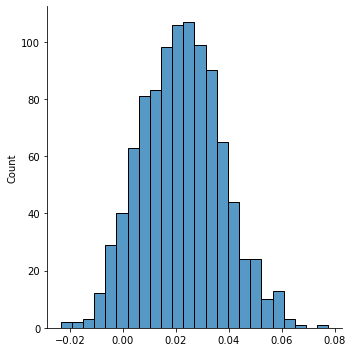

In [87]:
sns.displot(null_dist)
print(null_dist.shape)

# compute pvalue
pvalue = (null_dist >= val).mean()
print(val, pvalue)

In [80]:
print(null_dist.mean())

-0.2295729466226798


In [49]:
data = df.copy()

display(data.head())

,z,x,w,y,noise_var
0,-0.870662,-1.510891,-0.259173,1.086722,-0.834590
1,-1.367793,-0.212123,0.648893,-0.697208,0.248369
2,2.347410,0.595799,0.968497,-1.796433,-0.415533
3,-0.466953,-0.806082,-0.060690,0.815521,0.335198
4,0.575858,0.846430,1.398979,-1.032127,-0.229660


In [50]:
# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "x", "y", set())
print(r"CMI estimate for X \perp Y | {}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "x", "y", {"z"})
print(r"CMI estimate for X \perp Y | {z}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "x", "y", {"w"})
print(r"CMI estimate for X \perp Y | {w}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "x", "y", {"noise_var"})
print(r"CMI estimate for X \perp Y | {noise_var}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "x", "y", {"w", "noise_var", "z"})
print(r"CMI estimate for X \perp Y | {w, z, noise_var}: ", val)

CMI estimate for X \perp Y | {}:  0.0159178316934403
CMI estimate for X \perp Y | {z}:  0.01440012431879012
CMI estimate for X \perp Y | {w}:  0.009286282321393502
CMI estimate for X \perp Y | {noise_var}:  0.010371441974707851
CMI estimate for X \perp Y | {w, z, noise_var}:  -0.0017603427728243304


In [130]:
ci_est = "fisherz"
ci_estimator = FisherZCITest()
data = df.copy()

# compute the estimate of the CMI
_, val = ci_estimator.test(data, "x", "y", set())
print(r"CI estimate for X \perp Y | {}: ", val)

# compute the estimate of the CMI
_, val = ci_estimator.test(data, "x", "y", {"z"})
print(r"Ci estimate for X \perp Y | {z}: ", val)

# compute the estimate of the CMI
_, val = ci_estimator.test(data, "x", "y", {"w"})
print(r"Ci estimate for X \perp Y | {w}: ", val)

# compute the estimate of the CMI
_, val = ci_estimator.test(data, "x", "y", {"noise_var"})
print(r"Ci estimate for X \perp Y | {noise_var}: ", val)

# compute the estimate of the CMI
_, val = ci_estimator.test(data, "x", "y", {"w", "noise_var", "z"})
print(r"Ci estimate for X \perp Y | {w, z, noise_var}: ", val)

CI estimate for X \perp Y | {}:  0.00030317632384635473
Ci estimate for X \perp Y | {z}:  0.00014996543329592882
Ci estimate for X \perp Y | {w}:  0.38838419223141063
Ci estimate for X \perp Y | {noise_var}:  0.0002882658720682052
Ci estimate for X \perp Y | {w, z, noise_var}:  0.0001603625466857217


In [20]:
# preprocess the data
df = cmi_est._preprocess_data(df)

display(df.head())

,z,x,w,y,noise_var
0,-0.734725,0.889322,0.367746,1.856121,1.916435
1,2.309688,0.658690,0.644224,1.690991,-1.084692
2,1.667053,0.564517,0.825895,1.683689,-0.554238
3,0.557479,-0.196060,0.733319,-0.298586,-0.373313
4,-1.377411,-1.298313,0.738045,-2.287691,-0.218734


## Work with a nonlinear SCM

Instead of linear functionals, we're going to generate data of the form:

$$Y = g(\alpha X + \sigma)$$

where g(.) could be the cosine function. $\alpha$ is a set of weights applied to X variable and $\sigma$ is the standard noise deviation. This is known as a post-nonlinear additive noise model.

- A -> X -> Y <- Z
- X -> B
- Y -> C

In [6]:
rng = np.random.RandomState(seed=12345)

In [7]:
A, _, _ = nonlinear_additive_gaussian("ind", n_samples=2000, random_state=rng)
X, Y, Z = nonlinear_additive_gaussian("dep", n_samples=2000, cause_var_x=A)
B, C, _ = nonlinear_additive_gaussian(
    "ind", n_samples=2000, cause_var_x=X, cause_var_y=Y
)

In [8]:
cmi_est = CMITest(k=5, n_shuffle_nbrs=10)

In [9]:
df = pd.DataFrame(np.hstack((A, B, C, X, Y, Z)), columns=["A", "B", "C", "X", "Y", "Z"])

n_samples = 2000
df["noise_var"] = rng.normal(size=(n_samples,))
print(df.shape)
data = df

display(df.head())

(2000, 7)


,A,B,C,X,Y,Z,noise_var
0,0.987531,0.999998,0.953980,0.223388,0.692955,0.047796,-0.739706
1,0.771501,0.748731,0.700218,0.573959,-0.817687,0.708755,0.003547
2,0.974732,0.486675,0.180524,-0.262933,0.600671,1.496310,-0.067964
3,0.998927,0.685610,0.982027,0.565926,-0.352200,1.495563,1.530593
4,0.811509,0.849899,0.707577,0.344316,-0.166188,1.521334,1.359842


In [10]:
# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "X", "Y", set())
print(r"CMI estimate for X \perp Y | {}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data[["X", "Y", "Z"]], "X", "Y", {"Z"})
print(r"CMI estimate for X \perp Y | {Z}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "X", "Y", {"A"})
print(r"CMI estimate for X \perp Y | {A}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "X", "Y", {"B"})
print(r"CMI estimate for X \perp Y | {B}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "X", "Y", {"C"})
print(r"CMI estimate for X \perp Y | {C}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "X", "Y", {"noise_var"})
print(r"CMI estimate for X \perp Y | {noise_var}: ", val)

CMI estimate for X \perp Y | {}:  0.12990598941248943
CMI estimate for X \perp Y | {Z}:  0.3944831785817051
CMI estimate for X \perp Y | {A}:  0.12174495469054647
CMI estimate for X \perp Y | {B}:  0.10742312676380661
CMI estimate for X \perp Y | {C}:  0.15905499765029374
CMI estimate for X \perp Y | {noise_var}:  0.1521971503642312


In [41]:
cmi_est_tig = CMIknn()

arr = df[["X", "Y", "Z"]].to_numpy().T
dim, T = arr.shape
print(arr.shape)
xyz = np.array([0, 1, 2])
val = cmi_est_tig.get_dependence_measure(arr, xyz)
print(val)

(3, 2000)
0.13321043123014498


In [ ]:
# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "X", "Y", set())
print(r"CMI estimate for X \perp Y | {}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "X", "Y", {"Z"})
print(r"CMI estimate for X \perp Y | {Z}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "X", "Y", {"A"})
print(r"CMI estimate for X \perp Y | {A}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "X", "Y", {"B"})
print(r"CMI estimate for X \perp Y | {B}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "X", "Y", {"C"})
print(r"CMI estimate for X \perp Y | {C}: ", val)

# compute the estimate of the CMI
val = cmi_est._compute_cmi(data, "X", "Y", {"noise_var"})
print(r"CMI estimate for X \perp Y | {noise_var}: ", val)

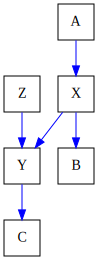

In [11]:
dag = DAG()
dag.add_edge("A", "X")
dag.add_edge("X", "Y")
dag.add_edge("X", "B")
dag.add_edge("Y", "C")
dag.add_edge("Z", "Y")
dag.draw()

# Analyze CMI phenomena in large-scale experiment

Modify variations of runs for each parametrizations of nonlinear functional:

- functional: cosine, exp, log, sine
- dims_z : 1 to 100 in steps of 2
- std: 0.1 to 3.0 in steps of 0.2

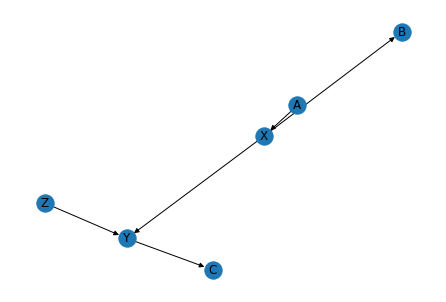

In [4]:
dag = nx.DiGraph()
dag.add_edge("A", "X")
dag.add_edge("X", "Y")
dag.add_edge("X", "B")
dag.add_edge("Y", "C")
dag.add_edge("Z", "Y")
nx.draw(dag, with_labels=True)

Assume z->y is known

Assuming there is now a dependency with y (y->* or *->y)
- Say x->y is weak and we see x \perp y
    - we can retest with x \perp y | z, and if there is truly an edge, then we should see an amplification
- Say y->c is weak, and we see c \perp y
    - when we retest with c \perp y | z, there wouldn't be a change (perhaps even more "independent")
    
Note in this setting: perhaps, we mark it as "weak" to prevent adding too many nodes to the conditioning set (e.g. in PC algo).

Also think about what happens if * is independent to y

Note: if we test B \perp Y and that is weak, we still want to be able to discover B \perp Y | X (later on)

In [5]:
nonlinear_funcs = [np.cos, np.exp, np.sin]
dims_zs = np.arange(1, 4, 2)
stds = np.arange(0.1, 1.5, 0.2)
n_samples = 1000

In [6]:
rng = np.random.default_rng()
seed = 12345
n_repeats = 5

In [7]:
def evaluate_cmi(data):
    result_dict = collections.defaultdict(list)
    cmi_est = CMITest(k=5, n_shuffle_nbrs=10)

    if "Z" in data.columns:
        z_covariates = {"Z"}
    else:
        z_covariates = {col for col in data.columns if col.startswith("Z_")}

    # compute the estimate of the CMI
    val = cmi_est._compute_cmi(data, "X", "Y", set())
    result_dict["cmi_null"].append(val)

    # compute the estimate of the CMI
    val = cmi_est._compute_cmi(data, "X", "Y", z_covariates)
    result_dict["cmi_z"].append(val)

    # compute the estimate of the CMI
    val = cmi_est._compute_cmi(data, "X", "Y", {"A"})
    result_dict["cmi_a"].append(val)

    # compute the estimate of the CMI
    val = cmi_est._compute_cmi(data, "X", "Y", {"B"})
    result_dict["cmi_b"].append(val)

    # compute the estimate of the CMI
    val = cmi_est._compute_cmi(data, "X", "Y", {"C"})
    result_dict["cmi_c"].append(val)

    # compute the estimate of the CMI
    val = cmi_est._compute_cmi(data, "X", "Y", {"noise_var"})
    result_dict["cmi_noise_var"].append(val)

    # create resulting dataframe
    result_df = pd.DataFrame.from_dict(result_dict)
    return result_df

In [8]:
jdx = -1
for dims_z in dims_zs:
    for nonlinear_func in nonlinear_funcs:
        for std in stds:
            jdx += 1

            if jdx == 14:
                print(
                    nonlinear_func,
                    std,
                    dims_z,
                )

print(jdx)
print(
    nonlinear_func,
    std,
    dims_z,
)

<ufunc 'sin'> 0.1 1
41
<ufunc 'sin'> 1.3000000000000003 3


In [ ]:
overall_res_df = pd.DataFrame()
jdx = -1

for nonlinear_func in nonlinear_funcs:
    for dims_z in dims_zs:
        for std in stds:
            overall_res_df = pd.DataFrame()

            jdx += 1
            # if jdx < 14:
            #     continue

            for idx in range(n_repeats):
                seed += idx
                # generate A as independent
                A, _, _ = nonlinear_additive_gaussian(
                    "ind",
                    n_samples=n_samples,
                    random_state=seed,
                    nonlinear_func=nonlinear_func,
                    dims_z=dims_z,
                    std=std,
                )

                # A -> X -> Y <- Z
                X, Y, Z = nonlinear_additive_gaussian(
                    "dep",
                    n_samples=n_samples,
                    cause_var_x=A,
                    random_state=seed,
                    nonlinear_func=nonlinear_func,
                    dims_z=dims_z,
                    std=std,
                )
                # X -> B; Y -> C
                B, C, _ = nonlinear_additive_gaussian(
                    "ind",
                    n_samples=n_samples,
                    cause_var_x=X,
                    cause_var_y=Y,
                    random_state=seed,
                    nonlinear_func=nonlinear_func,
                    dims_z=dims_z,
                    std=std,
                )

                df = pd.DataFrame()
                for col_name, arr in zip(
                    ["A", "B", "C", "X", "Y", "Z"], [A, B, C, X, Y, Z]
                ):
                    columns = [f"{col_name}_{idx}" for idx in range(arr.shape[1])]
                    if len(columns) == 1:
                        columns = [col_name]
                    _df = pd.DataFrame(arr, columns=columns)
                    df = pd.concat((df, _df), axis=1)
                df["noise_var"] = rng.normal(size=(n_samples,))

                result_df = evaluate_cmi(df)
                result_df["nonlinear_func"] = nonlinear_func.__name__
                result_df["dims_z"] = dims_z
                result_df["std"] = std
                result_df["idx"] = idx

                overall_res_df = pd.concat((overall_res_df, result_df), axis=0)

            fname = f"~/Downloads/cmi_results/cmi_{jdx}.csv"
            overall_res_df.to_csv(fname)
            # jdx += 1
    #         break
    #     break
    # break

In [ ]:
# print(X.shape, Y.shape, Z.shape, B.shape, C.shape, A.shape)
print(nonlinear_func.__name__)

In [ ]:
display(df.head())
display(result_df)

In [11]:
print("done")

done


## Analyze Results

In [49]:
data_dir = Path("/Users/adam2392/Downloads/cmi_results/")

df = pd.DataFrame()
for fname in data_dir.glob("*.csv"):
    # print(fname)
    df_ = pd.read_csv(fname, index_col=0)

    df = pd.concat((df, df_), axis=0)

df["index"] = df.reset_index().index

display(df.head())
print(df.shape)

,cmi_null,cmi_z,cmi_a,cmi_b,cmi_c,cmi_noise_var,nonlinear_func,dims_z,std,idx,index
0,3.358421,0.187708,0.169396,0.248679,1.286994,0.177218,square,3,1.1,0,0
0,3.890996,0.169368,0.150955,0.146168,1.176894,0.165677,square,3,1.1,1,1
0,3.309778,0.169918,0.165958,0.220249,1.315435,0.183287,square,3,1.1,2,2
0,3.236810,0.166685,0.173266,0.215667,1.347852,0.180872,square,3,1.1,3,3
0,2.377152,0.254809,0.221056,0.234956,1.406766,0.276586,square,3,1.1,4,4


(1260, 11)


In [63]:
plotdf = pd.melt(
    df,
    id_vars=["index", "nonlinear_func", "dims_z", "std"],
    value_vars=["cmi_null", "cmi_z", "cmi_a", "cmi_b", "cmi_c", "cmi_noise_var"],
    value_name="cmi",
    var_name="type",
)

plotdf = plotdf[~plotdf["nonlinear_func"].isin(["square", "cube_func"])]

display(plotdf.head())

,index,nonlinear_func,dims_z,std,type,cmi
5,5,sin,5,1.3,cmi_null,0.036175
6,6,sin,5,1.3,cmi_null,0.043613
7,7,sin,5,1.3,cmi_null,0.043067
8,8,sin,5,1.3,cmi_null,0.038393
9,9,sin,5,1.3,cmi_null,0.034626


<AxesSubplot:xlabel='type', ylabel='cmi'>

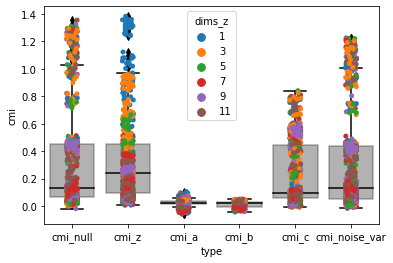

In [64]:
sns.stripplot(data=plotdf, x="type", y="cmi", hue="dims_z")
sns.boxplot(data=plotdf, x="type", y="cmi", color="black", boxprops=dict(alpha=0.3))

<AxesSubplot:xlabel='type', ylabel='cmi'>

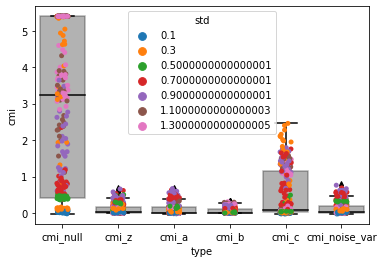

In [60]:
sns.stripplot(data=plotdf, x="type", y="cmi", hue="std")
sns.boxplot(data=plotdf, x="type", y="cmi", color="black", boxprops=dict(alpha=0.3))

<AxesSubplot:xlabel='type', ylabel='cmi'>

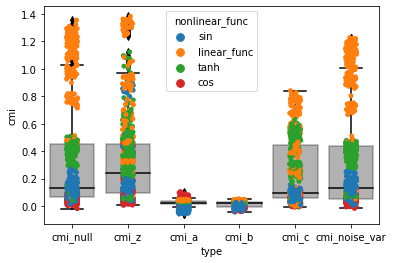

In [65]:
sns.stripplot(data=plotdf, x="type", y="cmi", hue="nonlinear_func")
sns.boxplot(data=plotdf, x="type", y="cmi", color="black", boxprops=dict(alpha=0.3))

In [74]:
sample_sizes = np.arange(1000, 1e5, 5000)
sample_sizes = np.linspace(500, 5000, 10)

In [75]:
print(sample_sizes)

[ 500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500. 5000.]
